# Stability

In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### Config

In [41]:
# Experimental setup arguments

class args:

    alpha = 0.2

    delta = 0.1

    epsilon = 0.01

    tau = 0.1

    lambda_max = 1.0

    L = 5.0

    T = 5  # number of iterations

    N = 10000  # number of samples in cohort

### Model

In [42]:
from data_prep import load_data

path_to_csv_file = './data/cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

n_training = 3000
X_train, X_rest, Y_train, Y_rest = train_test_split(X_all, Y_all, train_size=n_training, random_state=42)

d = X_all.shape[1] - 1
print('d=',d)

del X_all, Y_all

d= 10


In [43]:
import numpy as np

def subsample_by_N_and_percentage(X_rest, Y_rest, N, perc_ones, random_state=None):
    """
    Subsamples X_rest and Y_rest to produce a sample of size N with approximately the given percentage of ones.
    If there are not enough data points to reach N while respecting the percentage, the function reduces
    the sample size accordingly.
    
    Parameters:
      X_rest (np.ndarray): Array of features with shape (total_samples, ...).
      Y_rest (np.ndarray): Binary target array with shape (total_samples,).
      N (int): Desired sample size.
      perc_ones (float): Desired fraction of ones in the sample (e.g., 0.1 for 10% ones).
      random_state (int, optional): Seed for reproducibility.
      
    Returns:
      X_sample (np.ndarray): Subsampled features.
      Y_sample (np.ndarray): Subsampled binary targets with the desired class distribution.
    """
    # Set random seed for reproducibility if provided.
    if random_state is not None:
        np.random.seed(random_state)
    
    # Find indices for ones and zeros.
    ones_idx = np.where(Y_rest == 1)[0]
    zeros_idx = np.where(Y_rest == 0)[0]
    
    available_ones = len(ones_idx)
    available_zeros = len(zeros_idx)
    
    # Calculate desired numbers based on N and perc_ones.
    desired_n_ones = int(round(N * perc_ones))
    desired_n_zeros = N - desired_n_ones
    
    # Check if there are enough data points available.
    if available_ones < desired_n_ones or available_zeros < desired_n_zeros:
        # Compute the maximum number of ones that can be drawn while respecting the ratio.
        # For desired ratio: zeros/ones = (1 - perc_ones) / perc_ones.
        # We cannot have more than available_ones, and we also cannot use more zeros than available.
        max_n_ones_by_zeros = available_zeros * perc_ones / (1 - perc_ones) if perc_ones < 1 else available_ones
        new_n_ones = int(min(available_ones, max_n_ones_by_zeros))
        new_n_zeros = int(min(available_zeros, new_n_ones * (1 - perc_ones) / perc_ones))
        new_N = new_n_ones + new_n_zeros
        print("Not enough data points to achieve desired sample size. Reducing sample size to", new_N)
        desired_n_ones = new_n_ones
        desired_n_zeros = new_n_zeros
        N = new_N  # new sample size
    
    # Randomly choose indices for each class.
    selected_ones = np.random.choice(ones_idx, size=desired_n_ones, replace=False)
    selected_zeros = np.random.choice(zeros_idx, size=desired_n_zeros, replace=False)
    
    # Combine and sort indices if order matters.
    selected_indices = np.concatenate([selected_zeros, selected_ones])
    selected_indices.sort()
    
    return X_rest[selected_indices], Y_rest[selected_indices]


In [44]:
# X_cv, Y_cv = subsample_by_N_and_percentage(X_rest, Y_rest, args.N, 0.01, random_state=42)
X_cv, Y_cv = X_rest, Y_rest

In [45]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


In [46]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

In [47]:
model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)

[[-0.08785477 -0.44654791  1.48411659 -0.01750689 -0.60362931 -0.01524101
   0.67575508  0.11395415 -0.42184472  0.0886493  -0.37755321]]


In [48]:
res = model.predict_proba(X_train)[:,1]
print(res[:5])

[0.28702473 0.52977221 0.39262347 0.4731173  0.63574556]


In [49]:
res.sort()

In [50]:
res = model.predict_proba(X_cv)[:,1]
res.sort()
# max difference
np.max(res[1:] - res[:-1])

np.float64(0.009084435130568114)

### Set up



In [72]:
from typing import Union

import numpy as np
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



def type_II_error(Y, Y_proba, threshold):
    """Y=actual, Y_proba=predicted probability, threshold=threshold"""
    if len(Y.shape) != 1:
        Y = Y.reshape(-1,)
    if len(Y_proba.shape) != 1:
        Y_proba = Y_proba.reshape(-1,)
    return np.mean((Y == 1) * (Y_proba < 1 - threshold))


def piecewise_fn(Y_proba: np.ndarray, thresh: int):
    # clipping assumes loss btwn 0 and 1

    # lower_bound = (1 - thresh) - 1 / args.L
    # upper_bound = 1 - thresh
    # y = np.where(Y_proba < lower_bound, 1, 
    #              np.where(Y_proba > upper_bound, 0, 
    #                       1 - args.L * (Y_proba - (1 - thresh) + 1 / args.L)))

    # Optimization 1: use np.clip
    # y = np.clip(1 - args.L * (Y_proba - (1 - thresh) + 1 / args.L), 0, 1)

    # Optimization 2: compute less
    if len(Y_proba.shape) != 1:
        Y_proba = Y_proba.reshape(-1,)
    return np.clip(args.L * (1 - thresh - Y_proba), 0, 1)


def piecewise_loss(Y, Y_proba, thresh):
    if len(Y.shape) != 1:
        Y = Y.reshape(-1,)
    if len(Y_proba.shape) != 1:
        Y_proba = Y_proba.reshape(-1,)
    return ((Y == 1) * piecewise_fn(Y_proba, thresh)).reshape(-1,)


def surrogate_loss(Y, Y_proba, thresh):
    """l_{\tilde}"""
    return piecewise_loss(Y, Y_proba, thresh) + args.tau * (args.lambda_max - thresh)

In [ ]:
def get_next_thresh(loss_fn, Y, Y_proba, init_range=None, tol=1e-5, max_iter=30):

    # Choose two initial guesses.
    if init_range is None:
        t0, t1 = 0.0, 1.0
    else:
        t0 = max(0.0, init_range[0])
        t1 = min(1.0, init_range[1])
    
    f0, f1 = loss_fn(t0), loss_fn(t1)
    
    # If either guess is already close enough, return it.
    if abs(f0) < tol:
        return t0
    if abs(f1) < tol:
        return t1

    for _ in range(max_iter):
        # Prevent division by zero if f1 == f0.
        if f1 - f0 == 0:
            break

        # Secant update.
        t_new = t1 - f1 * (t1 - t0) / (f1 - f0)
        # Ensure t_new stays within [0, 1].
        t_new = np.clip(t_new, 0.0, 1.0)
        
        f_new = f(t_new)
        if abs(f_new) < tol:
            return t_new
        
        # Update our guesses.
        t0, f0 = t1, f1
        t1, f1 = t_new, f_new

    return t1


In [85]:
def get_new_features(X, model, thresh):
    # toy "optimization", either stay w/ current features or move by epsilon
    # to new features, depending on which has higher utility cost

    s = np.abs(model.coef_).argmax()
    onehot = np.zeros((1, len(model.coef_[0])))
    onehot[0, s] = 1
    sign = np.sign(model.coef_[0, s])

    # utility of not moving
    stay_utility_cost = np.squeeze(1 - piecewise_fn(model.predict_proba(X)[:,1], thresh))

    # utility of moving by epsilon
    X_move = X + sign * args.epsilon * onehot

    move_utility = np.squeeze(1 - piecewise_fn(model.predict_proba(X_move)[:,1], thresh))
    move_cost = (1 / (2 * args.epsilon / args.L) * np.square(X_move - X)).sum(axis=1)
    move_utility_cost = move_utility - move_cost

    mask = move_utility_cost > stay_utility_cost

    result = np.where(mask[:, np.newaxis], X_move, X)
    return result


In [86]:
from tqdm import tqdm

In [87]:
def run_iters(X, Y, verbose=False):

    losses = []
    threshes = []

    thresh = args.lambda_max
    thresh_diff = args.lambda_max

    iters = tqdm(range(args.T)) if verbose else range(args.T)

    for _ in iters:

        # Deploy threshold
        X_i = get_new_features(X, model, thresh)
        Y_proba = model.predict_proba(X_i)[:,1]

        # Calculate loss
        loss_i = piecewise_loss(Y, Y_proba, thresh).mean()

        # Update to new threshold, expect thresh difference to continue decreasing
        thresh_new = get_next_thresh(Y,
                                     Y_proba,
                                     init_range=(thresh - thresh_diff, thresh + thresh_diff),)
        thresh_diff = abs(thresh - thresh_new)
        thresh = thresh_new

        losses.append(loss_i)
        threshes.append(thresh)

    return thresh, losses, threshes

In [88]:
import numpy as np

def simulate_thresh_sensitivity(X_cv, Y_cv, num_trials=2):
    # Run on the full dataset to get the original threshold.
    orig_thresh, _, _ = run_iters(X_cv, Y_cv)

    thresh_list = []
    n = len(X_cv)
    
    # Ensure we don't exceed the number of available points.
    if num_trials > n:
        raise ValueError("num_trials cannot exceed the number of data points in X_cv.")

    # Get a random permutation of indices and select the first num_trials indices
    indices = np.random.permutation(n)[:num_trials]

    for idx in tqdm(indices):
        # Remove the selected data point from X_cv and Y_cv
        X_new = np.delete(X_cv, idx, axis=0)
        Y_new = np.delete(Y_cv, idx, axis=0)
        
        # Run run_iters on the modified dataset
        new_thresh, _, _ = run_iters(X_new, Y_new)
        thresh_list.append(new_thresh)
    
    # Convert to a NumPy array for vectorized operations
    thresh_array = np.array(thresh_list)
    
    # Calculate the maximum absolute difference from the original threshold
    max_diff = np.max(np.abs(thresh_array - orig_thresh))
    
    return max_diff


In [90]:
args.T = 5

In [95]:
args.T = 5
thresh, losses, threshes = run_iters(X_cv, Y_cv, verbose=True)
print(threshes)

100%|██████████| 5/5 [00:00<00:00, 267.80it/s]

[np.float64(0.4533964403486482), np.float64(0.4533964403486482), np.float64(0.4533964403486482), np.float64(0.4533964403486482), np.float64(0.4533964403486482)]


In [98]:
threshes[0]

np.float64(0.4533964403486482)

In [115]:
y_hat = model.predict_proba(X_cv)[:,1]
indicator = Y_cv * ((1 - threshes[0]) - 1 / args.L < y_hat) * (y_hat < 1 - threshes[0])

In [116]:
indicator.mean()

np.float64(0.18675522563000585)

In [126]:
(((1 - threshes[0]) - 1 / args.L < y_hat) * (y_hat < 1 - threshes[0])).mean()

np.float64(0.44377156996809275)

In [106]:
Y_cv.mean()

np.float64(0.45484144038549196)

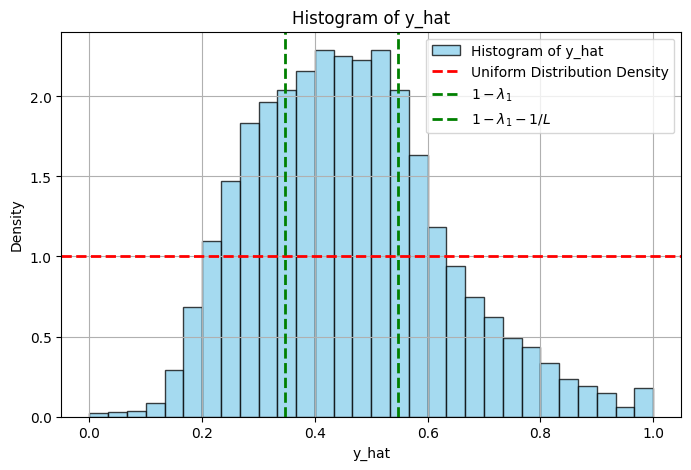

In [125]:
plt.figure(figsize=(8, 5))

# Plot histogram of y_hat
counts, bins, _ = plt.hist(y_hat, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')

# Overlay horizontal line for uniform distribution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Uniform Distribution Density')

plt.axvline(x=1 - threshes[0], color='green', linestyle='--', linewidth=2, label=r'$1-\lambda_1$')
plt.axvline(x=1 - threshes[0] - 1/args.L, color='green', linestyle='--', linewidth=2, label=r'$1-\lambda_1-1/L$')

# Labels and legend
plt.xlabel('y_hat')
plt.ylabel('Density')
plt.title('Histogram of y_hat')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [114]:
((1 - threshes[0]) - 1 / args.L < y_hat) * (y_hat < 1 - threshes[0])

array([ True,  True,  True, ...,  True, False, False], shape=(15357,))

In [111]:
(y_hat < 1 - threshes[0]).mean()

np.float64(0.7224718369473204)

In [ ]:
((1 - threshes[0]) - 1 / args.L < y_hat < 1 - threshes[0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [105]:
indicator.mean()

np.float64(0.45484144038549196)

In [29]:
max_diff = simulate_thresh_sensitivity(X_cv, Y_cv, num_trials=10)
max_diff

100%|██████████| 10/10 [01:00<00:00,  6.00s/it]


np.float64(0.00013503396087798103)